In [2]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [3]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 440744754


In [4]:
# define the plotting parameters

figsize = (8,4)

In [15]:
# import the data

# choose a TIC ID to analyze
ticid = 440744754

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)

# convert BTJD to HJD_UTC
target_coord = dict(ra=144.60971071725, dec=-57.53078180326)  # J2000 position in Gaia DR3 5306126331217598336 -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ682e694f26328a&-out.add=.&-source=I/355/gaiadr3&-c=144.60959350763%20-57.53074383030,eq=ICRS,rs=2&-out.orig=o
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord, cache_dir=f"tmp")

search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 09,2019,QLP,1800,440744754,0.0,N/A
1,TESS Sector 10,2019,QLP,1800,440744754,0.0,N/A
2,TESS Sector 36,2021,QLP,600,440744754,0.0,N/A
3,TESS Sector 37,2021,QLP,600,440744754,0.0,N/A
4,TESS Sector 62,2023,QLP,200,440744754,0.0,N/A
5,TESS Sector 63,2023,QLP,200,440744754,0.0,N/A
6,TESS Sector 64,2023,QLP,200,440744754,0.0,N/A
7,TESS Sector 89,2025,QLP,200,440744754,0.0,N/A
8,TESS Sector 90,2025,QLP,200,440744754,0.0,N/A


65283

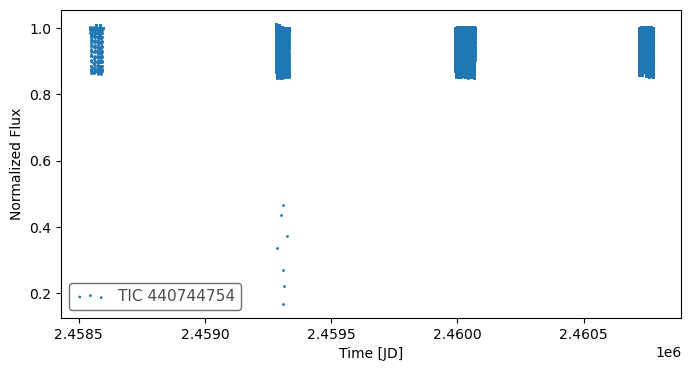

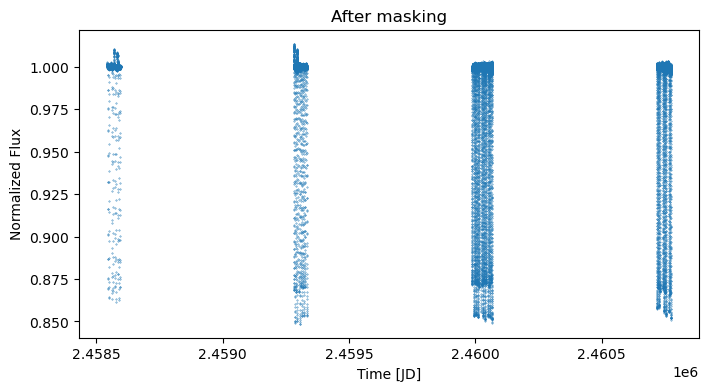

In [16]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# mask = flux < 0.85    # remove occasional outliers
mask = (
    ( flux < 0.8 )  # remove occasional lone outliers
)

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [42]:
len(time[(2459300 < time) & (time < 2459500)])

4315

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

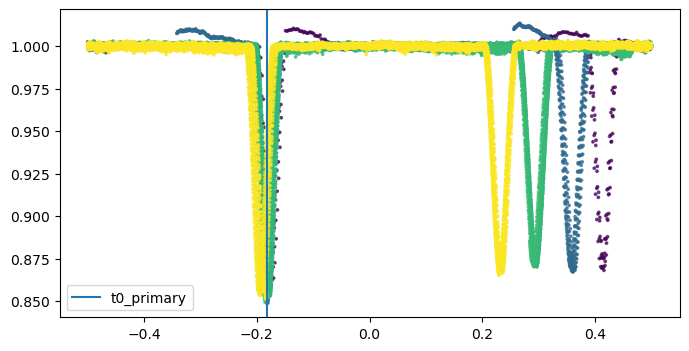

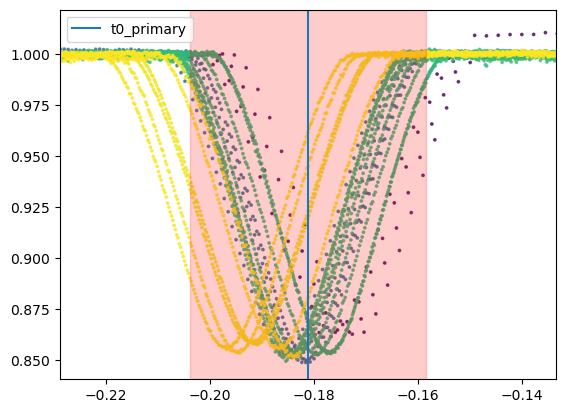

In [17]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# MCMC on df_primary: 7.146093281667767

# FILL-IN THE eclipse epoch / period,
period =  9.1914  # vSCXX

t0_primary = 2459304.467  # VSX, in HJD
t0_secondary = None  # ignore Min II for now, the best period is different

duration_hr_primary = 10  # VSX
duration_hr_secondary = None

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

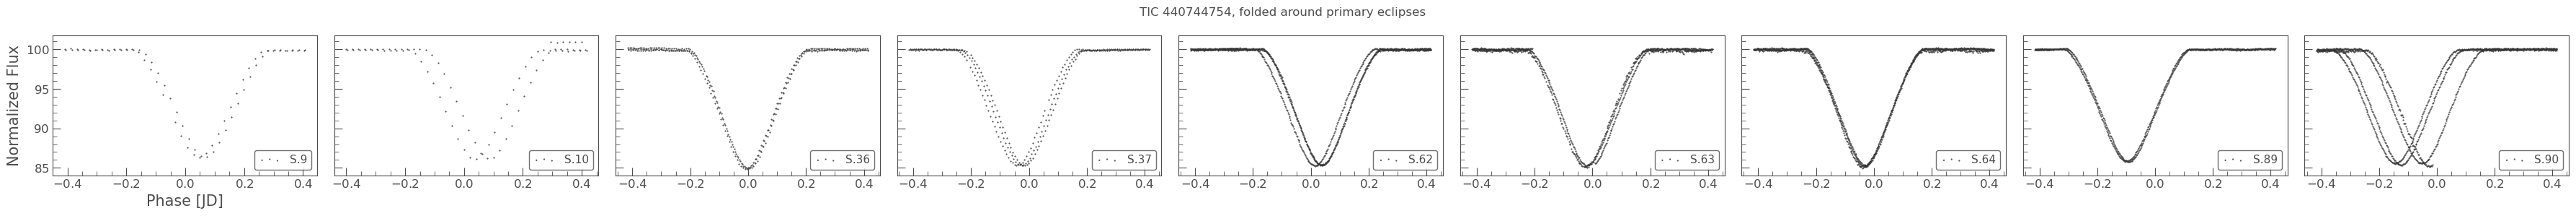

In [26]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    from astropy.time import Time
    t0_primary_btjd = Time(t0_primary, format="jd", scale="utc").to_value("btjd")  # an apprximate (missing UTC to BJD conversion),but good enough
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary_btjd)
        lc_f = lc_f.truncate(80, None, column="flux")
        lc_f = lc_f.truncate(-duration_hr_primary * 1 / 24, duration_hr_primary * 1 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# # ---
# with plt.style.context(lk.MPLSTYLE):
#     fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
#     if isinstance(axs, plt.Axes):
#         axs = [axs]
#     for i, lc in enumerate(lcc_tess):
#         lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
#         lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
#         ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
#         ax.legend(loc="lower right");
#         if i > 0:
#             ax.set_ylabel(None)
#             ax.set_xlabel(None)
#     fig.suptitle(f"{lc.label}, folded around secondary eclipses");
# plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [44]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 2.5 * duration_hr_primary / 24 / period   # accomodate large ETV
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.0, -0.145, midpoint_p, 0.012, 0.95]
# start_vals_s = None

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   2458550.7722 -0.1811911134195986
window_width_p (phase): 0.11333057713369746


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.145, 2458550.7722, 0.012, 0.95, 9.1914],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

In [ ]:
# use MCMC to refine the period

use_mcmc_to_fit_period = False  # for now we use VSX


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.125, 2458550.7722, 0.012, 0.95, 9.1914],
        nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        # nruns=2000, discard=600,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

In [ ]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [02:46<00:00, 18.00it/s]


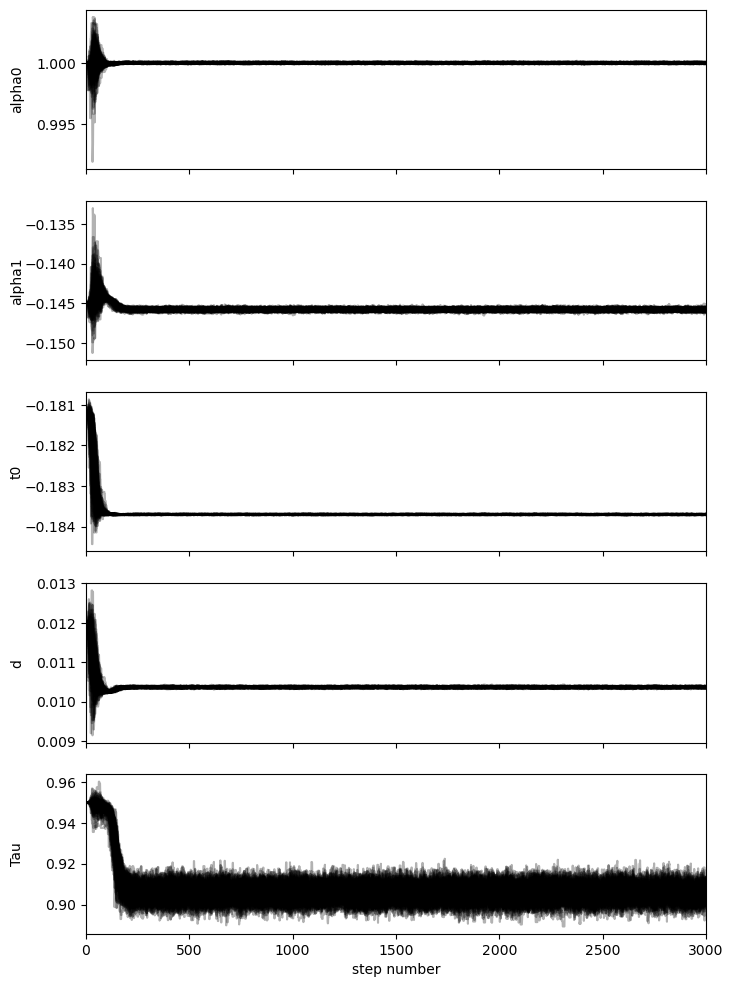

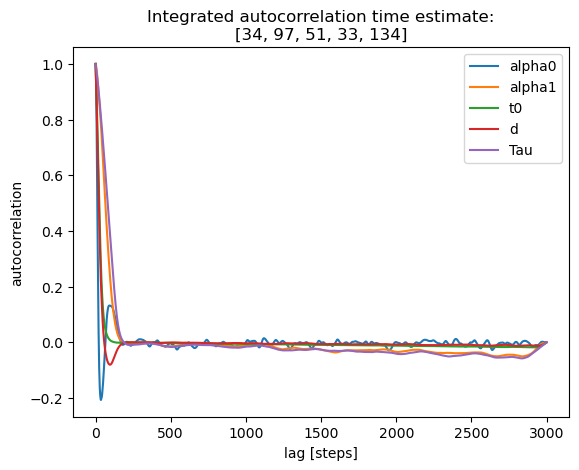

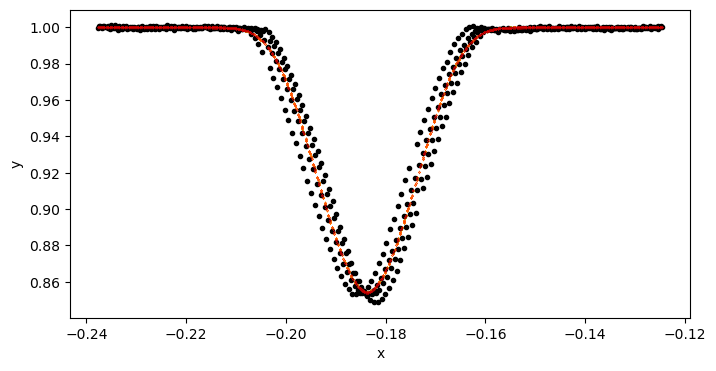

In [48]:
# run the initial model fit using MCMC for the primary and secondary eclipses
# (use a subset of data to reduce the folded lightcurve shape distortion)
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()

    # the ETV change is too great, for MCMC to fit properly, use a narrower window so that the fitted parameter would fit eclipse shape better, in particular alpha1 (amplitude)
    _data_primary = data_primary[(2459300 < data_primary.time) & (data_primary.time < 2459500)]
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(
        _data_primary, start_vals, 
        # nruns=20, discard=1,
        nruns=3000, discard=600,
        autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

In [31]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data (case use all data)
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau =  0.9997157945468225, -0.12159659469121546, -0.18476807843761653, 0.012379479196381016, 0.8791993146243621
    # initial fit params from TESS data (case use a subset of data to avoid the shfiting t0 time distoring the shape)
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.000015643884098, -0.1457748222164794, -0.18370191686329268, 0.01036814983967349, 0.9055885121206604
    
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [49]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.000015643884098, -0.1457748222164794, -0.18370191686329268, 0.01036814983967349, 0.9055885121206604


242

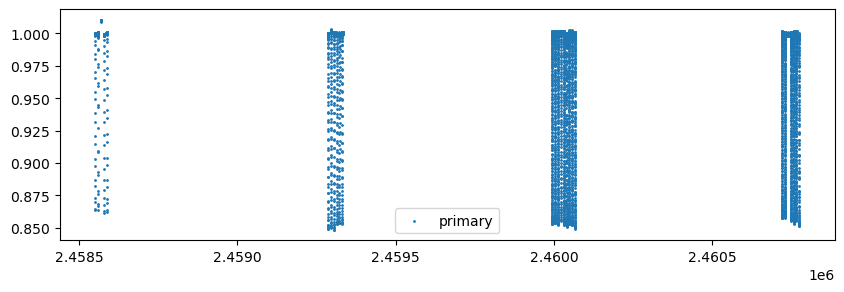

In [33]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

2458550.7722 9.1914 2458550.7722


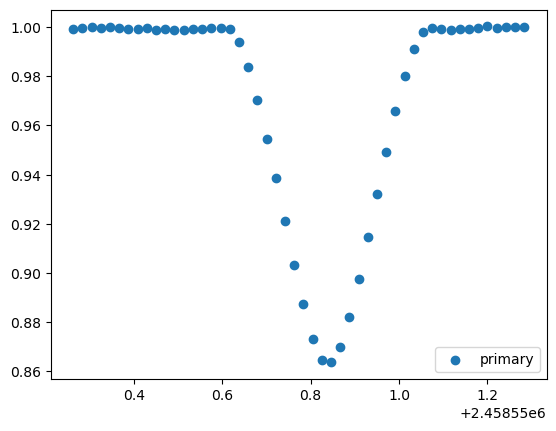

2458550.7722 9.1914 2458559.9636


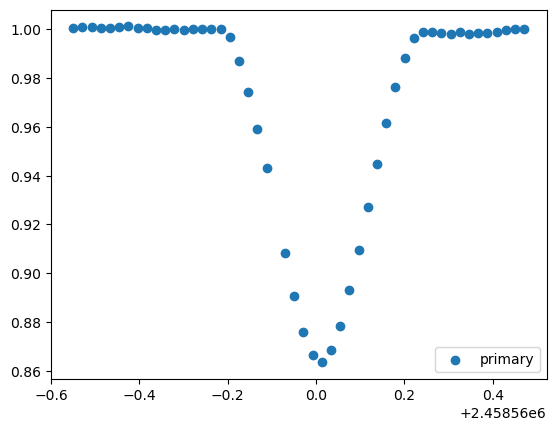

2458550.7722 9.1914 2458569.155


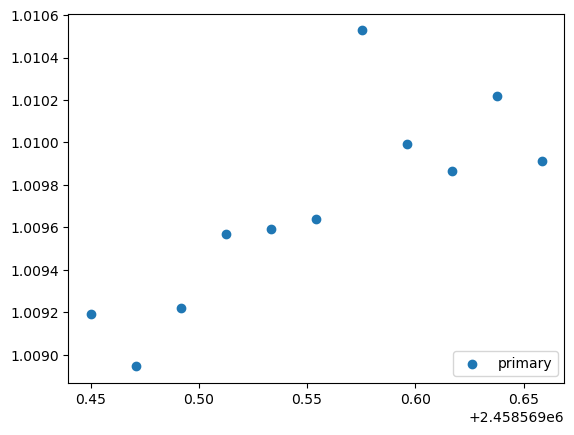

2458550.7722 9.1914 2460747.5168


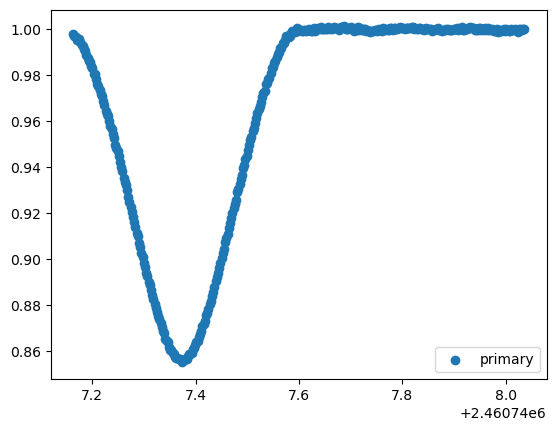

2458550.7722 9.1914 2460756.7082


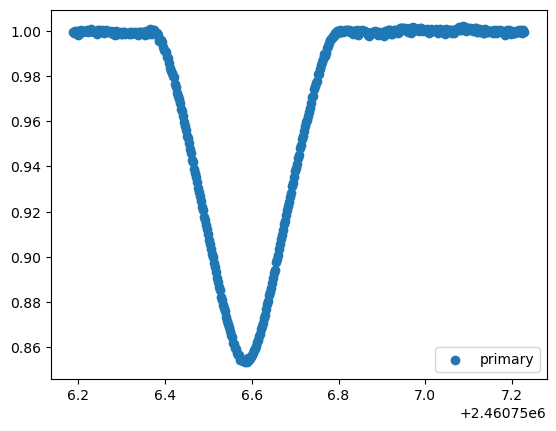

2458550.7722 9.1914 2460765.8996


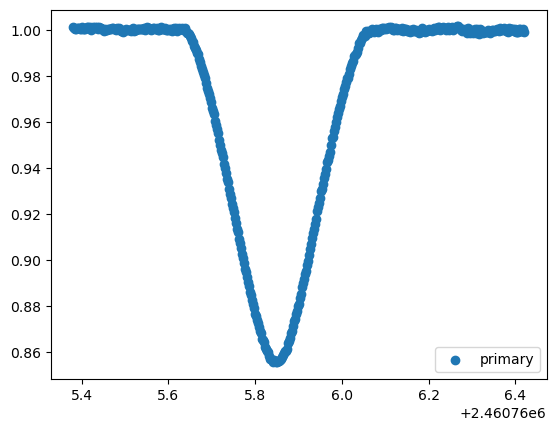

In [34]:
tr_index = range(0,n_transits)

for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [35]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(window_width_p  * period * 24 / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(window_width_s  * period * 24 / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) for primary: 50


Fitting individual primary eclipses...
Creating new manifest file
2458550.7722 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.66it/s]


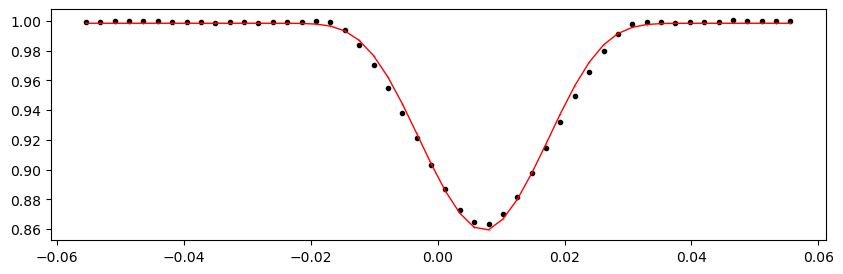

2458559.9636 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.52it/s]


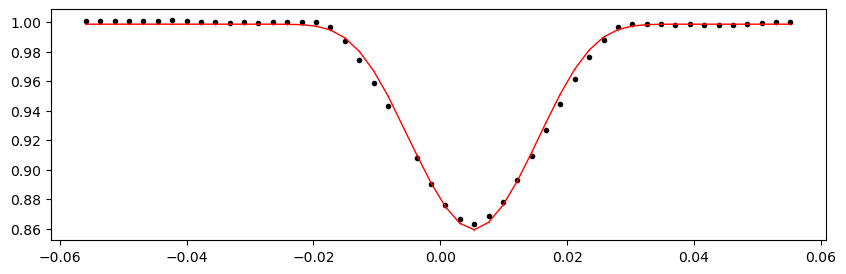

Time 2458569.155 does not have enough data points: 11
2458578.3464 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.58it/s]


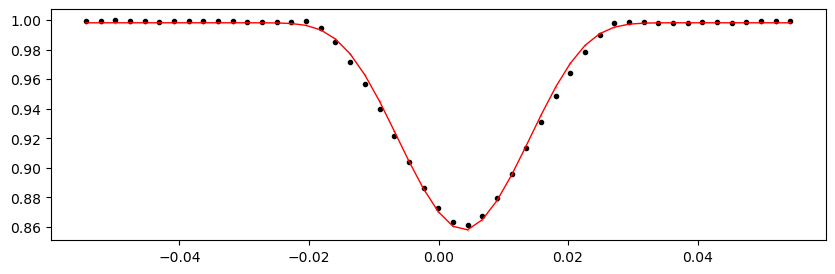

2458587.5378 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.39it/s]


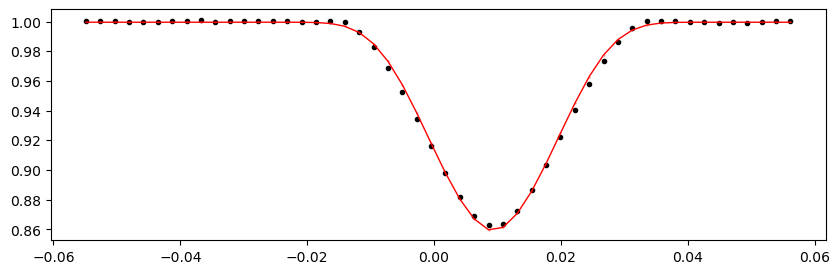

2459286.0842 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.94it/s]


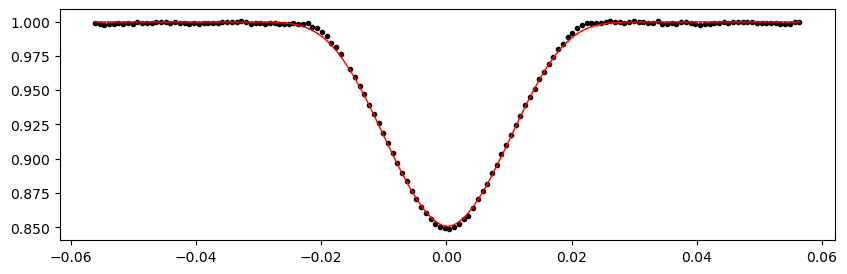

2459295.2756 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.29it/s]


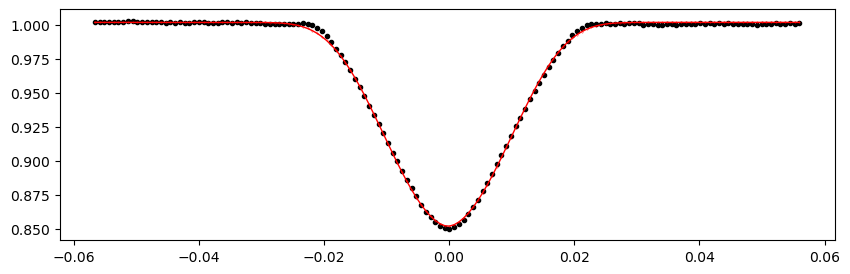

2459304.467 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.70it/s]


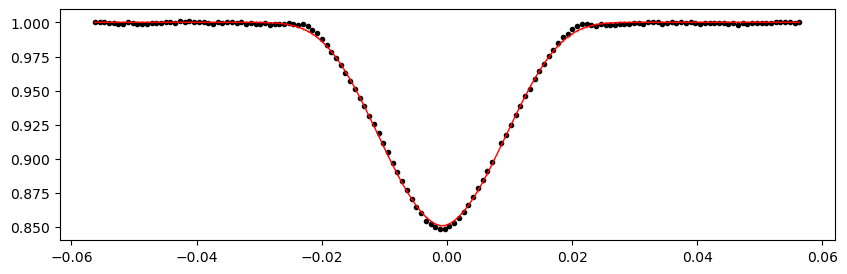

2459313.6584 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.11it/s]


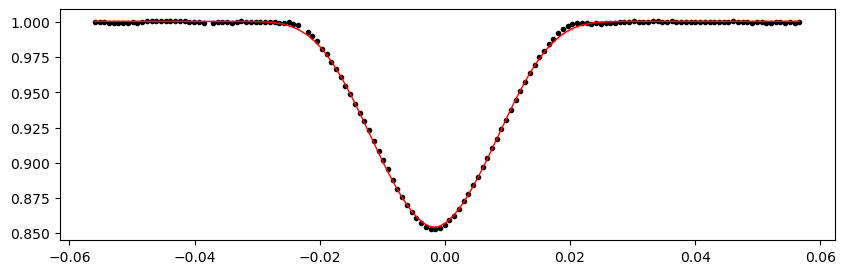

2459322.8498 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 374.72it/s]


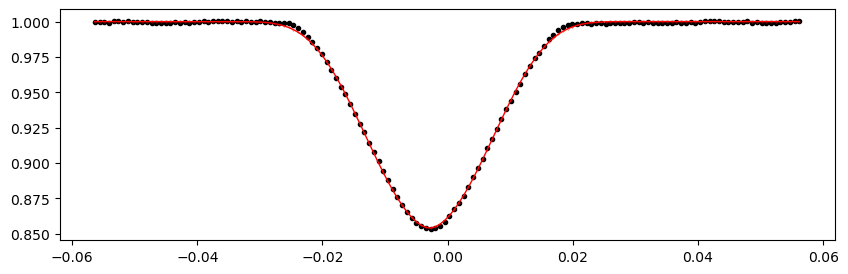

2459332.0412 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.45it/s]


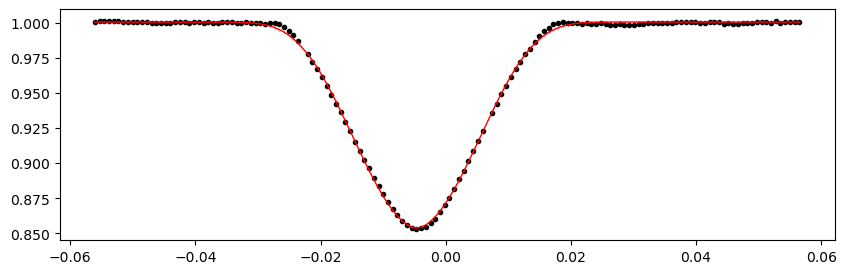

2459993.822 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 295.28it/s]


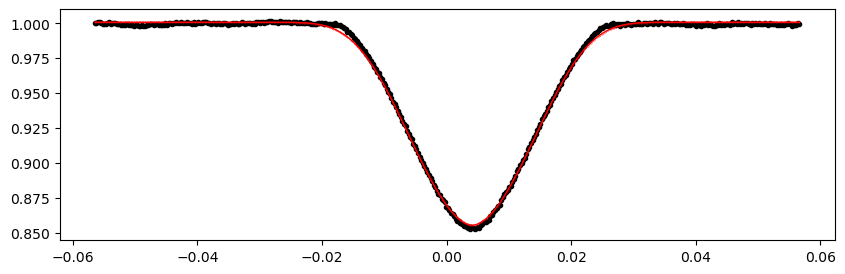

2460003.0134 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 291.74it/s]


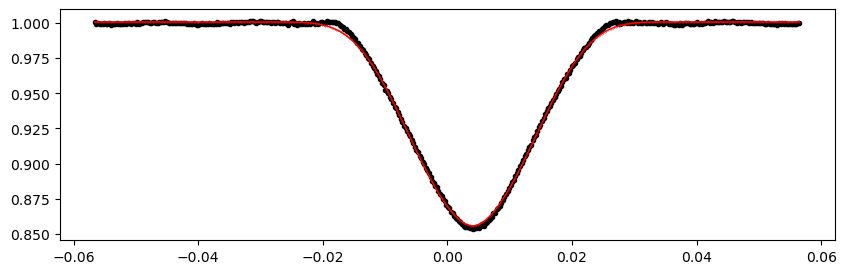

2460012.2048 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 288.02it/s]


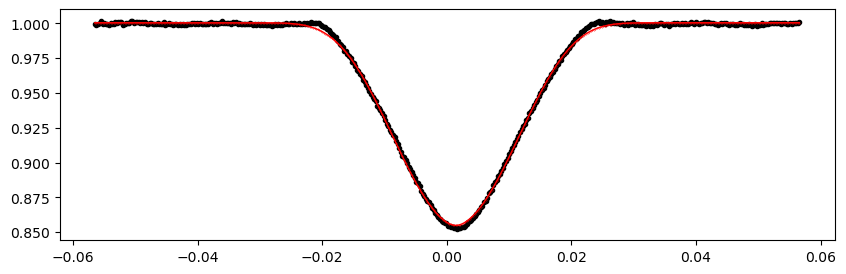

2460021.3962 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.92it/s]


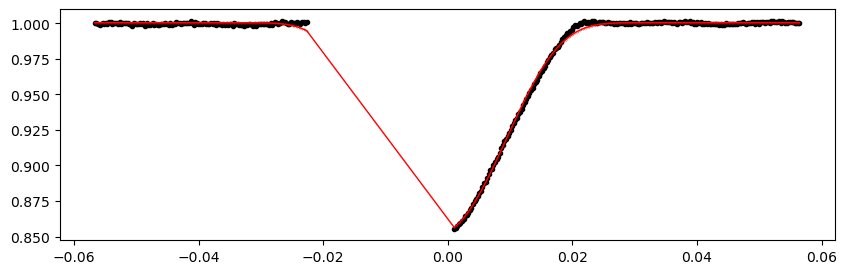

2460030.5876 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 286.87it/s]


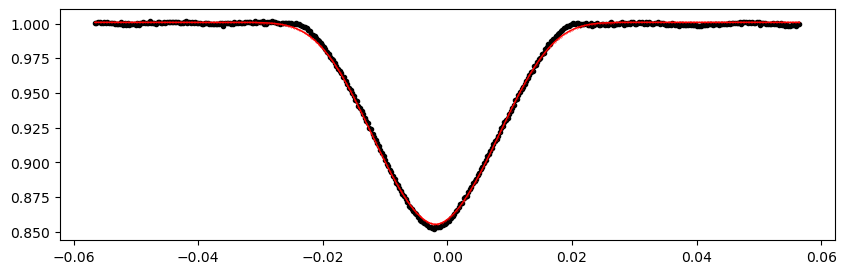

2460039.779 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.52it/s]


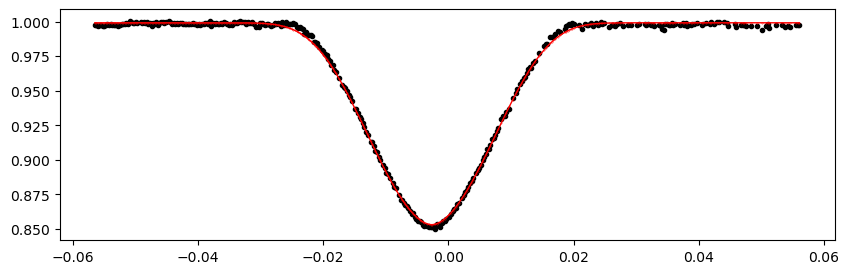

2460048.9704 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 294.09it/s]


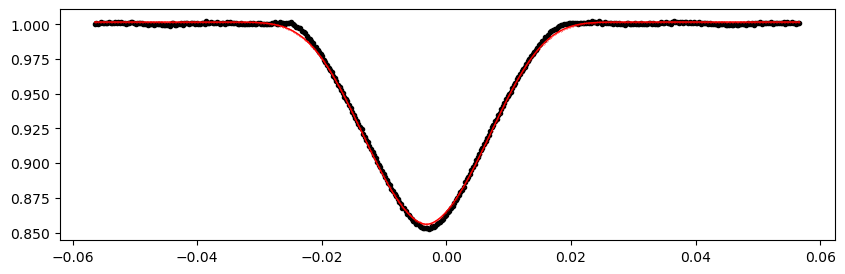

2460058.1618 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.23it/s]


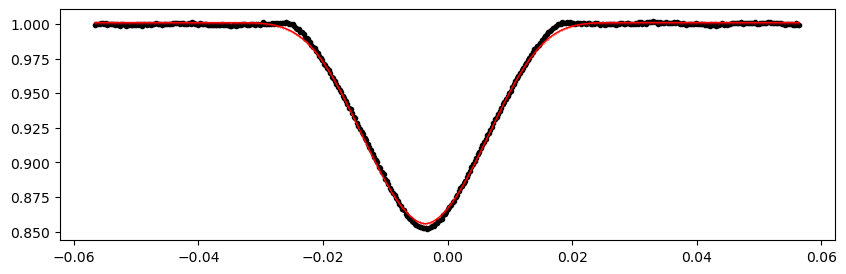

2460067.3532 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.24it/s]


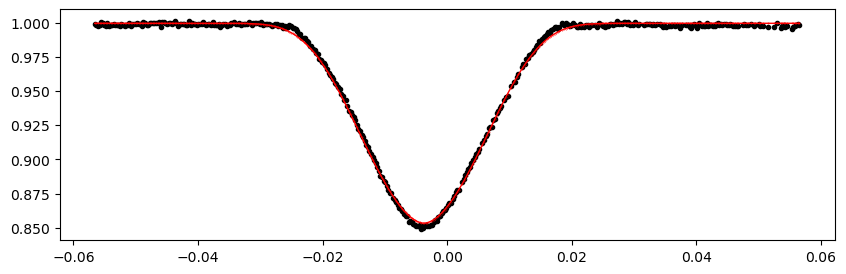

2460719.9426 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.06it/s]


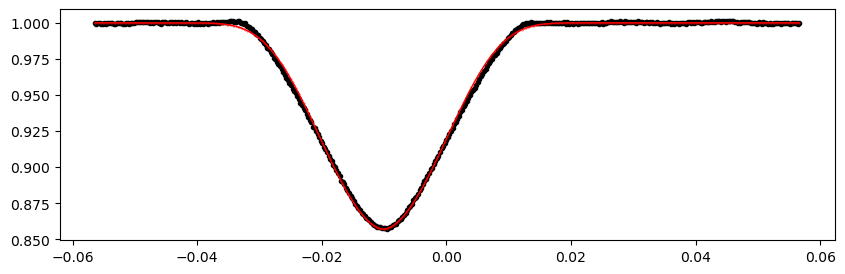

2460729.134 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 292.13it/s]


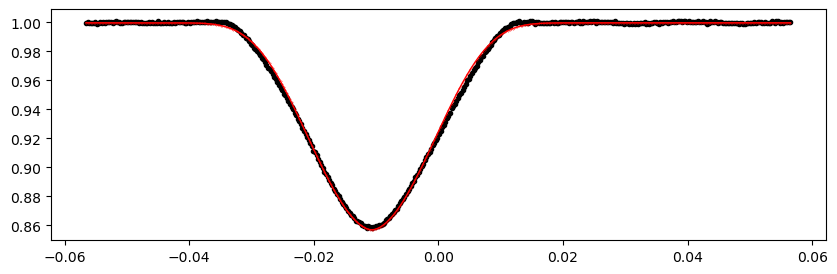

2460738.3254 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 523.05it/s]


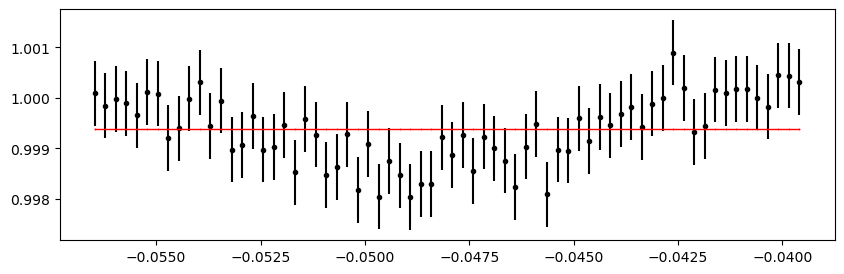

2460747.5168 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.92it/s]


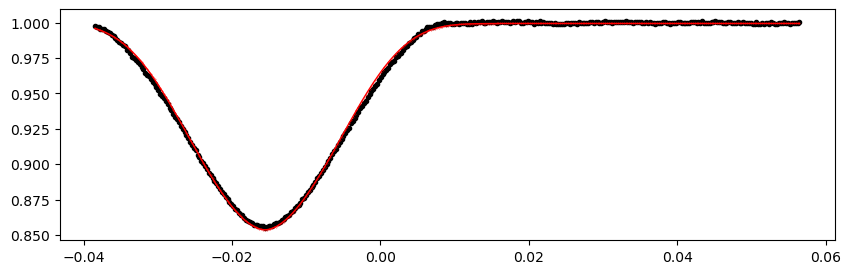

2460756.7082 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 302.46it/s]


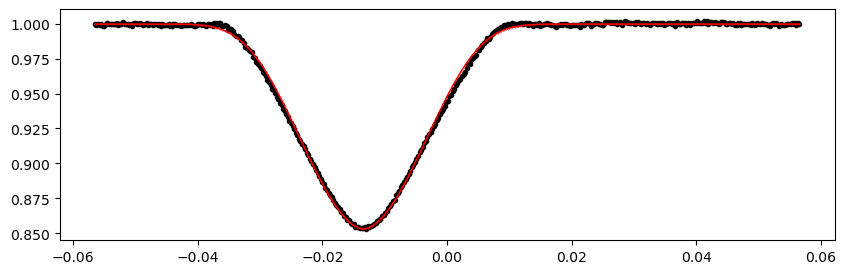

2460765.8996 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 300.50it/s]


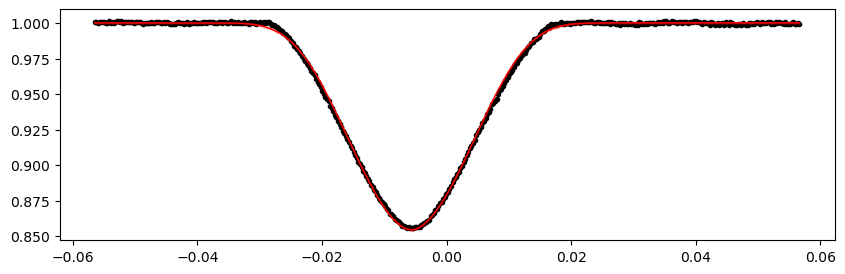

2460775.091 1.000015643884098 -0.1457748222164794 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 360.70it/s]


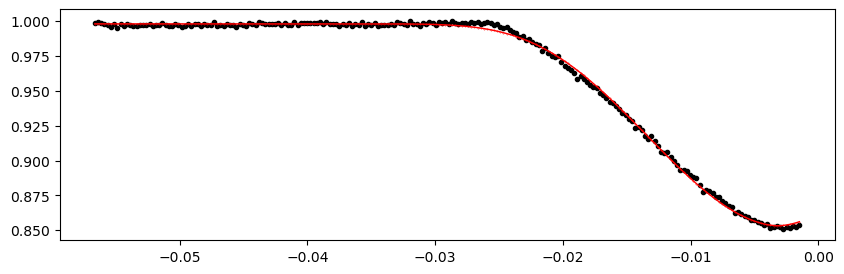

In [52]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, 
                               mean_alpha1, 
                               mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=20,
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


In [53]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=20,
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

No secondary eclipses defined. No-Op.


## ETV O-C plot

Note: 1 data points in df_primary filtered out due to huge O-C error.


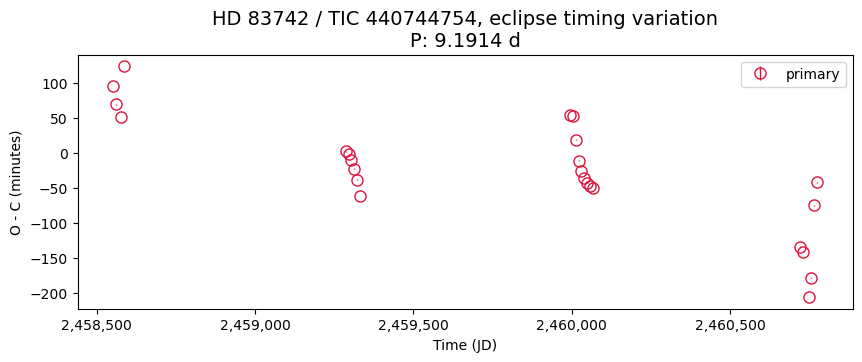

In [90]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"HD 83742 / TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

axs[-1].xaxis.set_major_formatter("{x:,.0f}")

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

In [85]:
in_df_primary

,number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau,midpoint,shift_mins,std_mins
0,0,2.458551e+06,0.998439,-0.139503,0.007267,0.000016,0.010368,0.905589,2.458551e+06,96.189251,0.214026
1,1,2.458560e+06,0.998649,-0.139359,0.005251,0.000017,0.010368,0.905589,2.458560e+06,69.494166,0.227183
2,3,2.458578e+06,0.998216,-0.140553,0.003902,0.000016,0.010368,0.905589,2.458578e+06,51.644165,0.214078
3,4,2.458588e+06,0.999553,-0.140544,0.009357,0.000016,0.010368,0.905589,2.458588e+06,123.851811,0.211558
4,80,2.459286e+06,0.999773,-0.149176,0.000176,0.000014,0.010368,0.905589,2.459286e+06,2.325900,0.187508
5,81,2.459295e+06,1.002036,-0.150049,-0.000158,0.000014,0.010368,0.905589,2.459295e+06,-2.097361,0.184387
6,82,2.459304e+06,1.000156,-0.149340,-0.000765,0.000014,0.010368,0.905589,2.459304e+06,-10.125464,0.188037
7,83,2.459314e+06,1.000397,-0.146200,-0.001684,0.000014,0.010368,0.905589,2.459314e+06,-22.284561,0.181379
8,84,2.459323e+06,1.000087,-0.146132,-0.002868,0.000014,0.010368,0.905589,2.459323e+06,-37.962333,0.180213
9,85,2.459332e+06,1.000389,-0.146547,-0.004646,0.000014,0.010368,0.905589,2.459332e+06,-61.487725,0.186207


### O-C Plot, Zoom In

,calc,observed,observed_iso,shift_mins
0,"2,458,550.772","2,458,550.839",2019-03-08 08:08:09.435,96.189
1,"2,458,559.964","2,458,560.012",2019-03-17 12:17:04.690,69.494
2,"2,458,578.346","2,458,578.382",2019-04-04 21:10:27.610,51.644
3,"2,458,587.538","2,458,587.624",2019-04-14 02:58:17.029,123.852


,calc,observed,observed_iso,shift_mins
4,"2,459,286.084","2,459,286.086",2021-03-12 14:03:34.434,2.326
5,"2,459,295.276","2,459,295.274",2021-03-21 18:34:45.998,-2.097
6,"2,459,304.467","2,459,304.460",2021-03-30 23:02:21.272,-10.125
7,"2,459,313.658","2,459,313.643",2021-04-09 03:25:48.686,-22.285
8,"2,459,322.850","2,459,322.823",2021-04-18 07:45:44.980,-37.962
9,"2,459,332.041","2,459,331.999",2021-04-27 11:57:50.417,-61.488


,calc,observed,observed_iso,shift_mins
10,"2,459,993.822","2,459,993.860",2023-02-18 08:38:21.640,54.681
11,"2,460,003.013","2,460,003.050",2023-02-27 13:12:43.099,53.422
12,"2,460,012.205","2,460,012.218",2023-03-08 17:14:08.676,19.233
13,"2,460,021.396","2,460,021.389",2023-03-17 21:19:34.163,-10.959
14,"2,460,030.588","2,460,030.570",2023-03-27 01:41:01.326,-25.122
15,"2,460,039.779","2,460,039.754",2023-04-05 06:06:15.463,-35.502
16,"2,460,048.970","2,460,048.941",2023-04-14 10:34:58.359,-42.403
17,"2,460,058.162","2,460,058.129",2023-04-23 15:05:39.026,-47.342
18,"2,460,067.353","2,460,067.319",2023-05-02 19:38:55.333,-49.686


,calc,observed,observed_iso,shift_mins
19,"2,460,719.943","2,460,719.850",2025-02-13 08:23:42.723,-133.632
20,"2,460,729.134","2,460,729.036",2025-02-22 12:51:37.012,-141.343
22,"2,460,747.517","2,460,747.374",2025-03-12 20:58:22.423,-205.818
23,"2,460,756.708","2,460,756.585",2025-03-22 02:01:54.936,-177.892
24,"2,460,765.900","2,460,765.848",2025-03-31 08:20:33.224,-74.870
25,"2,460,775.091","2,460,775.062",2025-04-09 13:29:02.972,-41.990


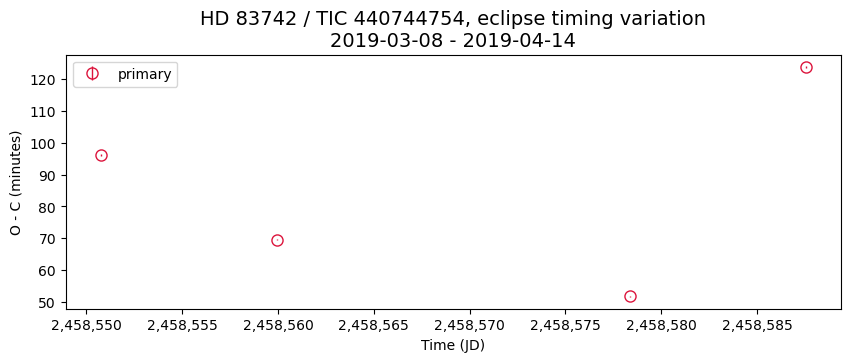

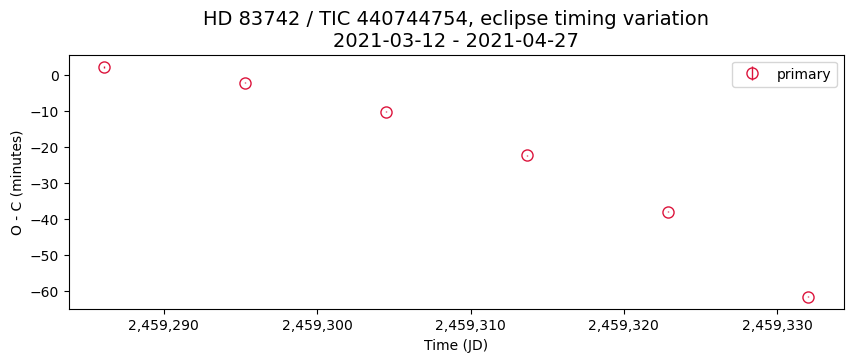

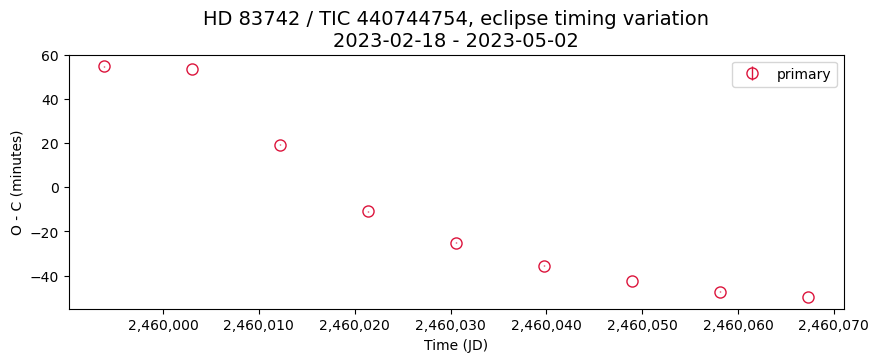

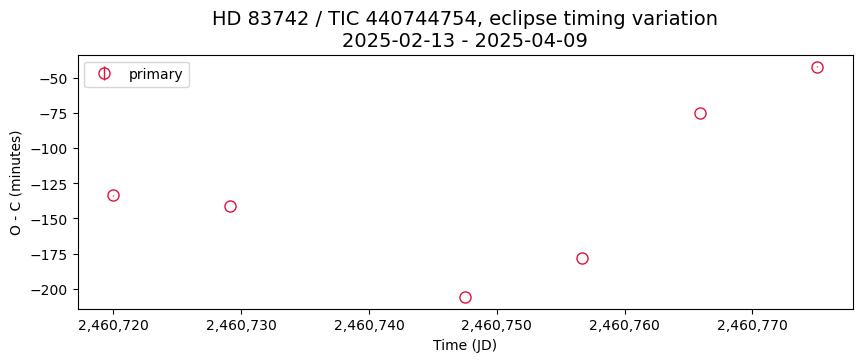

In [91]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (2458500, 2458700),
    (2459250, 2459500),
    (2459900, 2460200),
    (2460600, 2460900),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        with pd.option_context('display.float_format', "{:,.3f}".format, 'display.max_rows', 999, 'display.max_columns', 99):
            df = df_zoom.copy()
            df["calc"] = df.epoch
            df["observed"] = df.midpoint
            df["observed_iso"] = Time(df.midpoint, format="jd", scale="utc").to_value(format="iso")
            display(df[["calc", "observed", "observed_iso", "shift_mins"]])
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
        axs[-1].xaxis.set_major_formatter("{x:,.0f}")

        def iso_date(hjd_time):
            import re
            res = Time(hjd_time, format="jd", scale="utc").to_value(format="isot")
            res = re.sub("T.+", "", res)
            return res
            
        _title = f"HD 83742 / TIC {ticid}, {title_suffix}"
        _title += f"""\n{iso_date(df_zoom.epoch.iloc[0])} - {iso_date(df_zoom.epoch.iloc[-1])}"""
        axs[0].set_title(_title, fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
# plt.xlim(0, 1000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if False:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    tweak_axs(axs)

## Results Summary

In [92]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests strong variations. The period is probably not too accurate but it is difficult to get a good period given the strong variations."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

,0
tic,440744754
has_etv,Y
comments,O-C suggests strong variations. The period is probably not too accurate but it is difficult to get a good period given the strong variations.
period,9.1914
depth_pct_p,14.58
depth_pct_s,None
epoch_p,2458550.7722
epoch_s,None
num_sectors,9
time_span,2231.84



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
440744754,Y,O-C suggests strong variations. The period is probably not too accurate but it is difficult to get a good period given the strong variations.,9.1914,14.58,,2458550.7722,,9,2231.84,2458543.24,2460775.08

